In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from IPython.display import clear_output
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.compat.v2.feature_column as fc




In [3]:

df = pd.read_csv('insurance.csv')

df.shape

(1338, 7)

In [4]:
# sample 20% of the dataframe for training purposes
df_train = df.sample(frac=0.8, random_state=42)

# the remaining 80% of the dataframe can be used for testing/validation
df_test = df.drop(df_train.index)

In [5]:
print(df_train.shape)
print(df_test.shape)

(1070, 7)
(268, 7)


In [6]:
bin_edges = [-float('inf'), 1000, 5000, 10000, 20000, float('inf')]

In [7]:
test_label = pd.cut(df_test['expenses'], bins=bin_edges, labels=[0, 1, 2 , 3, 4]).astype(int)
train_label = pd.cut(df_train['expenses'], bins=bin_edges, labels=[0, 1, 2, 3, 4]).astype(int)


In [10]:
train_pop = df_train.pop('expenses')
test_pop = df_test.pop('expenses')


<AxesSubplot: >

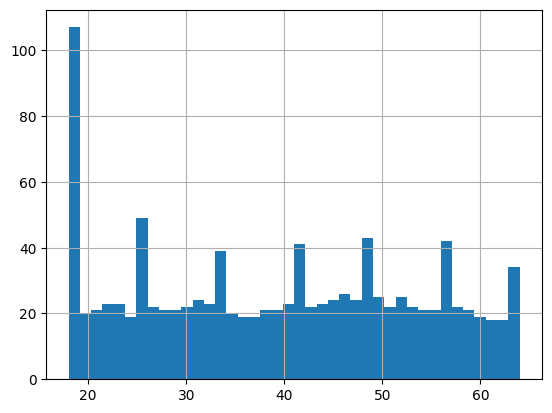

In [11]:
df_train.age.hist(bins=40)

In [12]:
df_train.head()

,age,sex,bmi,children,smoker,region
764,45,female,25.2,2,no,northeast
887,36,female,30.0,0,no,northwest
890,64,female,26.9,0,yes,northwest
1293,46,male,25.7,3,no,northwest
259,19,male,31.9,0,yes,northwest


In [13]:
CATEGORICAL_COLUMNS = ['sex', 'smoker', 'region']
NUMERIC_COLUMNS = ['age', 'bmi', 'children']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = df_train[feature_name].unique()  # gets a list of all unique values from given feature column
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('female', 'male'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='smoker', vocabulary_list=('no', 'yes'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='region', vocabulary_list=('northeast', 'northwest', 'southwest', 'southeast'), dtype=tf.string, default_value=-1, num_oov_buckets=0), NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='bmi', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='children', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [14]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(df_train, train_label)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(df_test, test_label, num_epochs=1, shuffle=False)

In [15]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\mgsou\\AppData\\Local\\Temp\\tmpi4muu22s', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [16]:
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data

clear_output()  # clears consoke output
print(result['accuracy'])  # the result variable is simply a dict of stats about our model

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\mgsou\AppData\Local\Temp\tmpi4muu22s\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


InvalidArgumentError: Graph execution error:

assertion failed: [Labels must be <= n_classes - 1] [Condition x <= y did not hold element-wise:] [x (head/losses/Cast:0) = ] [[4][4][2]...] [y (head/losses/check_label_range/Const:0) = ] [1]
	 [[{{node Assert}}]]

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
